In [1]:
import sys, os
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_DIR = os.path.join(BASE_DIR, "src")
sys.path.append(SRC_DIR)

In [2]:
import os
import random
import json 
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
from reporting.explore_stats_sumry import summarize_dataset_exclusive, classify_doc
from utils.io_utils import ensure_dir, read_jsonl, sample_jsonl, sample_docs
from reporting.explore_stats_sumry import quick_stats, show_longest_docs, summarize_dataset, summarize_dataset_exclusive
from tokenization.tokenizers import BOS_ID, EOS_ID, PAD_ID
from tokenization.tokenizers import base_enc, tokenize_to_jsonl, token_length_stats, tokenize_ext_to_jsonl
from tokenization.packers import pack_to_fixed_blocks, diagnose_packed_lengths
from tokenization.sharders import shard_packed_dataset


# Read clean file

In [3]:
clean_data_path='../data/clean'
clean_file=os.path.join(clean_data_path, "mainpipe_clean_data2.jsonl")

In [4]:
summary, summary_pct = summarize_dataset_exclusive(clean_file, sample_size=25000)
print(summary)
print(summary_pct)

Counter({'GOOD_ENGLISH': 24842, 'SHORT_ENGLISH': 102, 'HTML': 56})
{'GOOD_ENGLISH': 99.368, 'HTML': 0.22399999999999998, 'SHORT_ENGLISH': 0.40800000000000003}


In [5]:
sum(i for i in list(summary_pct.values()))

100.0

### my cleaning pipiline is able to clean most code-heavy docs 

# Quick stats

In [6]:
quick_stats(clean_file, sample_size=25000)

FILE OVERVIEW
File size: 200.95 MB (0.20 GB)
Total lines in file: 107,320
Sampled (limit): 25,000
------------

KEYS
Most common keys: [('text', 25000)]
------------

TEXT LENGTH STATS
Avg length: 1829.51
Median length: 845.00
10th percentile: 284.00
90th percentile: 3951.00
Most entries are multi-paragraph documents (median text size>300).
Good for LLM pretraining (rich context, natural text).
Max length: 49749
raw HTML pages,  code dumps / stack traces, JSON logs or config files, full chat transcripts, base64 or encoded junk.
 These must be  filtered or trim these before LLM pretraining
Min length: 126
------------

NOISE INDICATORS
Empty texts: 0 (0.00%)
Short < 100 chars: 0 (0.00%)
Only a small fraction of trivial/low-value text.  Dataset likely contains substantial natural text, not noise
------------

Done.


for line in random.sample(list(open(clean_file)), 10000):
    row = json.loads(line)
    text = row["text"]
    if classify_doc(text) == "CODE_HEAVY":  #HTML CODE_HEAVY
        print(text[:500])
        print("-----")


When using strong code detect, there is 44% code heavy detection. So, when I print code heavy out of 20, 11 are found heavy. When I inspect those, only three 3 look like codes.
This is because after normalization each document (could be paragraph worth text) is one big line, and if in thatbig line there is any code-like simple, you get code_lines / len(lines)=1 which is >0.4. So the whole document is classified as code heavy now.

# Tokenization

Choosing the right tokenizer for data preprocessing in Natural Language Processing (NLP) depends on several factors, including the language of your data, the specific NLP task, and the characteristics of your dataset.
For English language with clear boundaries, for goal of semantic understanding (not very fine-grained analysis), Subword Tokenization should work well.

Subword Tokenization, such as Byte Pair Encoding, WordPiece, SentencePiece, balances vocabulary size and the ability to handle OOV words by breaking words into smaller units (subwords) based on statistical frequency. Subword Tokenization is important for tge model to extract meening and to generalize models learning to new words. Tokenization methos affects the speed and cost of both training (pretraining) and inference (generating responses).

In [7]:
#GPT-2 style BPE
#base_enc=tiktoken.get_encoding("gpt2")

### Tokenizing few lines first

In [8]:
sample_documents = sample_docs(clean_file, n=2)

In [9]:
for i, text in enumerate(sample_documents):
    print(f"\n=== sample_documents {i} ===")
    print(text[:500], "...")
    tokens = base_enc.encode(text)
    print(f"Token count: {len(tokens)}")
    print("First 30 token IDs:", tokens[:30])
    print("Decode check:\n", base_enc.decode(tokens[:80]), "...")


=== sample_documents 0 ===
VinodKumar, K.; Aboobacker, V.M.; Saheed, P.P.; Vethamony, P.
Measurements and numerical simulations carried out off Mumbai coast for the period 22 October to 22 November 2009 showed significant variations in water level and currents during cyclone Phyan. Changes in the meridional component of the current velocity were found to be highly significant during Phyan. The strong southward flow due to the cyclone resulted in a complete nullification of a flood current and continued the net flow toward ...
Token count: 304
First 30 token IDs: [53, 259, 375, 42, 44844, 11, 509, 15089, 317, 2127, 672, 10735, 11, 569, 13, 44, 15089, 10318, 23616, 11, 350, 13, 47, 15089, 49744, 2763, 1647, 11, 350, 13]
Decode check:
 VinodKumar, K.; Aboobacker, V.M.; Saheed, P.P.; Vethamony, P.
Measurements and numerical simulations carried out off Mumbai coast for the period 22 October to 22 November 2009 showed significant variations in water level and currents during cyclone Phyan. 

# Tokenizing whole samples

In [10]:
token_lengths = token_length_stats(clean_file, encoder=base_enc, max_docs=None)  # or a subset first

Docs counted: 107320
Avg tokens   : 437.26
Median tokens: 203.00
95th pct     : 1376.00
99th pct     : 4184.24
Max tokens   : 14150


### Most docs are relatively short (median = 203). 
### 1%> 4184. A small tail of long documents exists up to ~14k tokens
### 95% documents have token length <= 1376

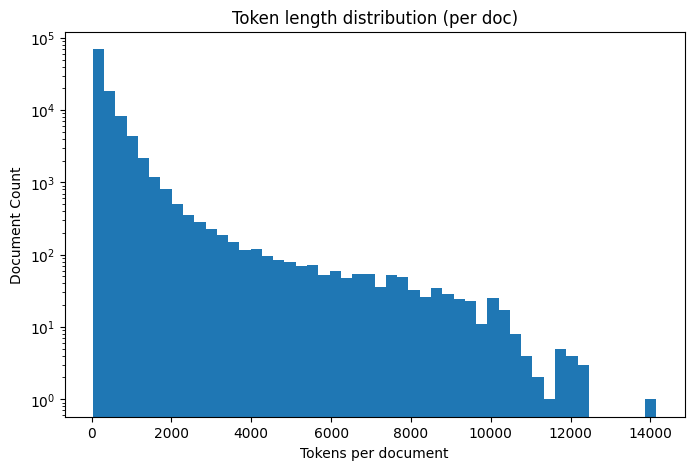

In [11]:
plt.figure(figsize=(8,5))
plt.hist(token_lengths, bins=50)
plt.xlabel("Tokens per document")
plt.ylabel("Document Count")
plt.title("Token length distribution (per doc)")
plt.yscale("log")  # often useful
plt.show()

10^5 docs in the 0–300 token range. Half of all docs < 203 tokens (median)
dataset is dominated by short/medium natural text.

### TODO
- decide max_seq_len for training (e.g. 1024, 2048, 4096).
- Whether many docs are longer than max_seq_len then chunking needed

### Because 95% documents have token length < 2048
### Setting Context window i.e. max_seq_len=2048
that should be appropriate for a small custom LLM

In [12]:
tokenized_path = "../data/final/mainpipe_tokenized_gpt2.jsonl"
tokenize_to_jsonl(clean_file, tokenized_path, encoder=base_enc, max_seq_len=2048)

Read docs : 107320
Wrote docs: 107320


 During pretraining, the model learns the statistical relationships and patterns between tokens (e.g., which tokens frequently follow others) to predict the next token in a sequence. The quality of the tokenization directly affects how effectively the model can learn these relationships, impacting its overall accuracy and capability.

Next
- add special tokens
- Packing. group short documents together and padding to build 2048 size tokens. for efficiency and p
- fixed lens training blocks by padding to build 2048
- convert to model ready  data such as shards

For large-scale training, this dataset is compatible with any PyTorch/JAX framework that accepts binary shards (Megatron, HF Trainer, DeepSpeed). The pipeline is structured so that the output can be consumed by these frameworks with minimal loading overhead.


### Special tokens
BOS	Beginning of sequence	Mark the start of a document

EOS	End of sequence	Mark document boundaries

PAD	Padding	For batching sequences during training

SEP	Separator	separates different pieces

UNK	Unknown	replacement for unknown chars


In [13]:
start_id1 = base_enc.n_vocab 

In [14]:
print("Base GPT-2 vocab:", base_enc.n_vocab)

Base GPT-2 vocab: 50257


special_tokens = {
    "<|bos|>": start_id,
    "<|eos|>": start_id + 1,
    "<|pad|>": start_id + 2,
    "<|unk|>": start_id + 3,
}

enc = tiktoken.Encoding(
    name="gpt2_extended",
    pat_str=base_enc._pat_str,
    mergeable_ranks=base_enc._mergeable_ranks,
    special_tokens=special_tokens
)

In [15]:
from tokenization.tokenizers import enc_ext

In [16]:
print("Extended vocab:", enc_ext.n_vocab)

Extended vocab: 50261


In [17]:
print(enc_ext._special_tokens) #note attribute '_special_tokens'

{'<|bos|>': 50257, '<|eos|>': 50258, '<|pad|>': 50259, '<|unk|>': 50260}


In [18]:
tokenized_path2 = "../data/final/mainpipe_tokenized_gpt2_V2.jsonl"
tokenize_ext_to_jsonl(clean_file, tokenized_path2, encoder=enc_ext, max_seq_len=2048)

Read docs : 107320
Wrote docs: 107320


In [19]:
read_jsonl(tokenized_path2, n=5)

{'input_ids': [50257, 818, 262, 1239, 7464, 3344, 284, 5755, 12926, 286, 663, 36814, 7557, 11, 6283, 3996, 23299, 1666, 422, 262, 12926, 6355, 2055, 11, 257, 5863, 8489, 290, 2766, 422, 1111, 4671, 389, 18116, 284, 11508, 8850, 978, 2093, 504, 326, 24435, 262, 1814, 1276, 307, 262, 717, 2239, 13, 632, 815, 307, 262, 938, 290, 691, 706, 584, 4237, 286, 6426, 389, 3938, 18782, 13, 1081, 6542, 679, 320, 417, 7584, 366, 314, 4236, 326, 257, 9068, 4610, 815, 6211, 262, 36814, 7557, 12042, 11, 475, 938, 11, 407, 717, 13, 3274, 1100, 3137, 278, 262, 3056, 1687, 11, 584, 6426, 4237, 11, 26740, 15401, 12224, 11, 6630, 11, 290, 691, 706, 883, 815, 262, 7557, 338, 12042, 307, 3177, 13, 2312, 661, 389, 4684, 284, 1577, 1964, 3002, 284, 262, 4734, 11, 508, 423, 1464, 16563, 262, 36814, 7557, 6949, 13, 1148, 340, 1016, 284, 3520, 262, 2368, 6787, 286, 12926, 4819, 30, 18578, 1911, 50258], 'length': 158}
{'input_ids': [50257, 1212, 1107, 373, 281, 10059, 9476, 13, 1649, 314, 2067, 3555, 11, 616, 5110

# Packing 

### Variable length blocks (only last padded to 2048)
Works for LLM pretraining, saves 5-15% compute time but not efficient for training foundation models using GPUs.


# Fixed length blocks 
might 5-15% compute more time but efficient for training foundation models using GPUs.
For LLM pretraining at production scale,  fixed-length 2048-token blocks (with padding) is better, as it guarantees static shapes and full compatibility with distributed training frameworks like Megatron-LM or DeepSpeed.


In [20]:
packed_path = "../data/final/mainpipe_token_packed.jsonl"
pack_to_fixed_blocks(tokenized_path2, packed_path, encoder=enc_ext, block_size=2048, pad_token="<|pad|>")

Total fixed-length blocks written: 24207


In [21]:
diagnose_packed_lengths(tokenized_path2, packed_path, block_size=2048)


=== Checking ORIGINAL token lengths (FULL) ===
Total original docs: 107320
Min original length: 33
Max original length: 2048
Avg original length: 379.90

=== Checking PACKED blocks (FULL) ===
Total packed blocks: 24207
Unique packed block lengths: {2048}
All packed blocks are EXACTLY 2048 tokens.


### Sharding

In [22]:
packed_path = "../data/final/mainpipe_token_packed.jsonl"
out_dir = "../data/final/sharded_dataset"

shard_packed_dataset(
    packed_path,
    out_dir,
    train_ratio=0.98,
    val_ratio=0.01,
    test_ratio=0.01,
    shard_size=50000
)



Total blocks: 24207
Train blocks (98.0%): 23722
Val blocks   (1.0%): 242
Test blocks  (1.0%): 243

Sharding completed.
Train shards: 1
Val shards:   1
Test shards:  1
